In [32]:
%reset -f

In [33]:
import os, sys

ROOT_PATH = os.path.abspath(".").split("src")[0]

module_path = os.path.abspath(os.path.join(ROOT_PATH+"/src/utils/"))
module_path_venv = os.path.abspath(os.path.join(ROOT_PATH+"/venv/lib/python3.6/site-packages/"))
if module_path not in sys.path:
    sys.path.append(module_path)
    sys.path.insert(0, module_path_venv)

from statsmodels.graphics.gofplots import qqplot

import pickle
import math
import numpy as np
import pandas as pd
import seaborn as sns
import itertools

from matplotlib import rc
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from scipy import stats as scstats
from sklearn.linear_model import LinearRegression
from functions import MAE, RMSE, split_dataset

import keras
import tensorflow as tf
import functions as f
import dl_functions as dlf

SEED=100
np.random.seed(SEED)
tf.set_random_seed(SEED)

In [34]:
#DEC 2018
start_dec = 17500
end_dec = 19500

#APRIL 2018
start_april = 2000
end_april = 4000

#JULY 2018
start_july = 10500
end_july = 13500

# DELTA = 3

In [35]:
# set plot settings
sns.set()
sns.set_context('paper')
sns.set_style('whitegrid', {'axes.grid': True, 'grid.linestyle': '--'})
c, palette = f.color_palette()
sns.set_palette(palette)

rc('figure', figsize=(12,6), dpi=200)
rc('xtick', labelsize=14)
rc('ytick', labelsize=14)
rc('axes', labelsize=14, titlesize=14)
rc('legend', fontsize=14, handlelength=2)
rc('font', family='serif')
rc('text', color="#000000")
rc('xtick', color="#000000")
rc('ytick', color="#000000")

In [36]:
# Load models
lstm = keras.models.load_model(ROOT_PATH + "models/ensemble/lstm_model.h5")
mlp = keras.models.load_model(ROOT_PATH + "models/ensemble/mlp_model.h5")
lm = f.load_pickle(ROOT_PATH + "models/ensemble/linear_model.pkl")

In [37]:
# read data and metadata
df_train, df_valid, df_test, a_04, a_07, a_12 = f.load_data(return_anomaly=True)

# split datasets into features and targets
x_valid, y_valid = f.split_dataset(df_valid.values, delay=1)
x_04, y_04 = f.split_dataset(a_04.values, delay=1)
x_07, y_07 = f.split_dataset(a_07.values, delay=1)
x_12, y_12 = f.split_dataset(a_12.values, delay=1)

stats, ts, ts_train, ts_valid, ts_test = f.load_metadata()

# metadata
target_tags = a_04.columns.values[:3]
feature_tags = a_04.columns.values[3:]
target_stds = stats.loc[:,"Std"][:3]
target_means = stats.loc[:,"Mean"][:3]

t_04 = a_04.index.values
t_07 = a_07.index.values
t_12 = a_12.index.values

In [38]:
print(a_04.shape, a_07.shape, a_12.shape)
print("April dataset:    ", a_04.index[0],"to", a_04.index[-1])
print("July dataset:     ", a_07.index[0],"to", a_07.index[-1])
print("December dataset: ", a_12.index[0],"to", a_12.index[-1])

(43166, 9) (44638, 9) (41753, 9)
April dataset:     2018-04-01 00:00:00 to 2018-04-30 23:59:00
July dataset:      2018-07-01 00:00:00 to 2018-07-31 23:59:00
December dataset:  2018-12-01 00:00:00 to 2018-12-29 23:58:00


In [39]:
n_pred=150

In [41]:
y_hat_04, std_preds_04 = dlf.predict_with_ensemble(
    lm, 
    lstm, 
    mlp, 
    x_04, 
    y_04, 
    n_pred=n_pred
)

In [42]:
y_hat_07, std_preds_07 = dlf.predict_with_ensemble(
    lm, 
    lstm, 
    mlp, 
    x_07, 
    y_07, 
    n_pred=n_pred,
)

In [43]:
y_hat_12, std_preds_12 = dlf.predict_with_ensemble(
    lm, 
    lstm, 
    mlp,
    x_12, 
    y_12, 
    n_pred=n_pred
)

In [44]:
predicted_valid, std_preds_valid = dlf.predict_with_ensemble(
    lm, 
    lstm, 
    mlp,
    x_valid, 
    y_valid,
    n_pred=n_pred,
)

In [45]:
# Create residual distribution
def create_residual_distribution(signal, plot = True):
    N = 5

    res_dist = predicted_valid[:,signal] - y_valid[:,signal]
    rolling_smoothed = pd.Series(res_dist).rolling(window=N).mean().iloc[N-1:].values
    
    data = res_dist
    mu, std = scstats.norm.fit(data)

    if plot:
        positions = [111]
        fig = plt.figure(figsize=(8,4))
        # fig.suptitle('Signal: {}'.format(signal), fontsize=16)
        axs = [fig.add_subplot(i) for i in positions]
        axs[0].hist(data, bins=25, density=True, alpha=0.6)
        
        # Plot the PDF.
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = scstats.norm.pdf(x, mu, std)
        axs[0].plot(x, p, 'k', linewidth=2, c=c["blue_dark"], label='${0}(\mu={1}, \sigma={2})$'.format("\mathcal{N}", round(mu,2), round(std,2)))
        plt.legend()
        # title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
        # axs[0].set_title(title)
        
    return rolling_smoothed

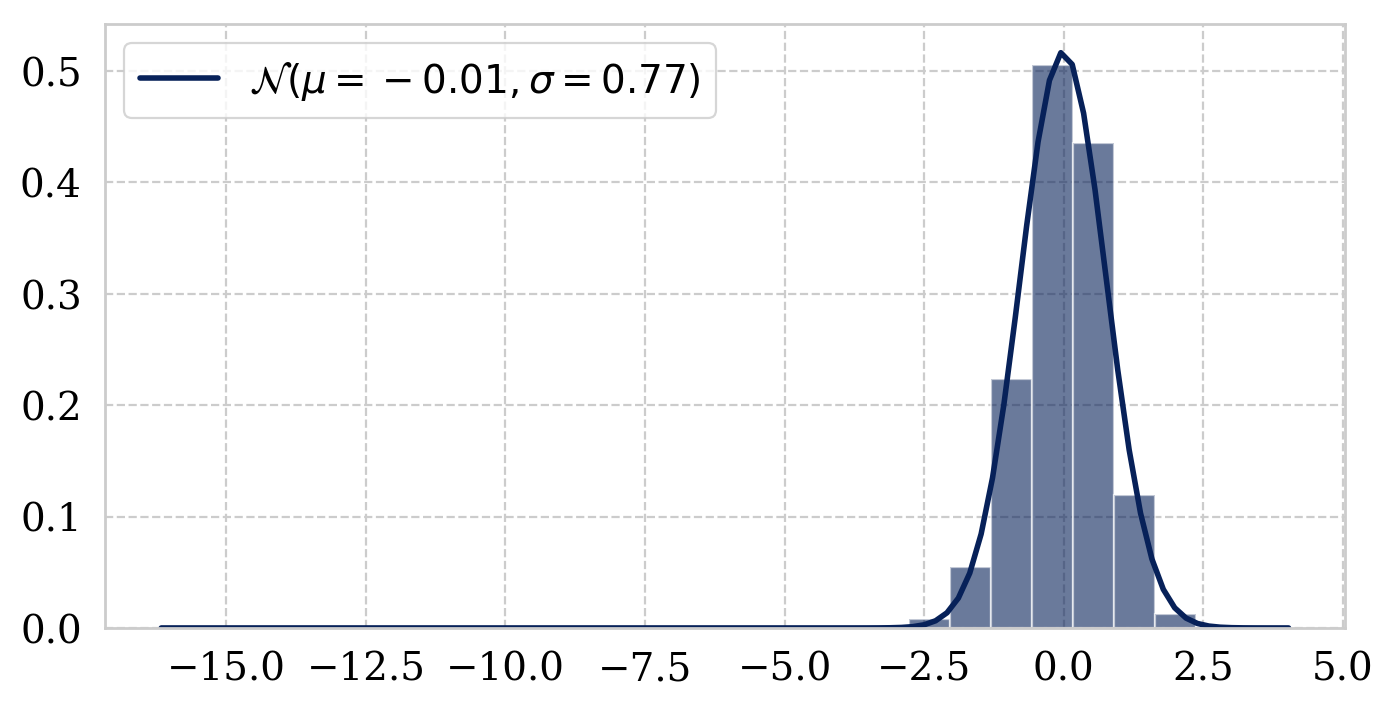

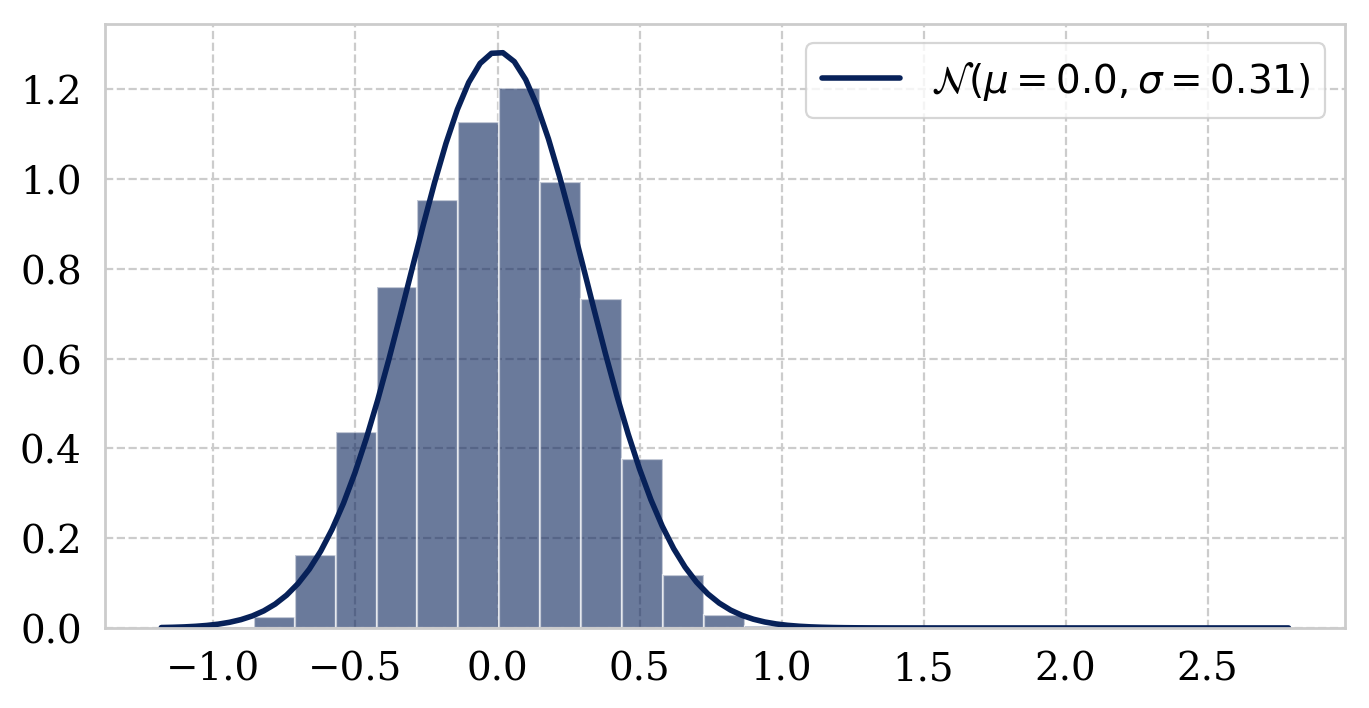

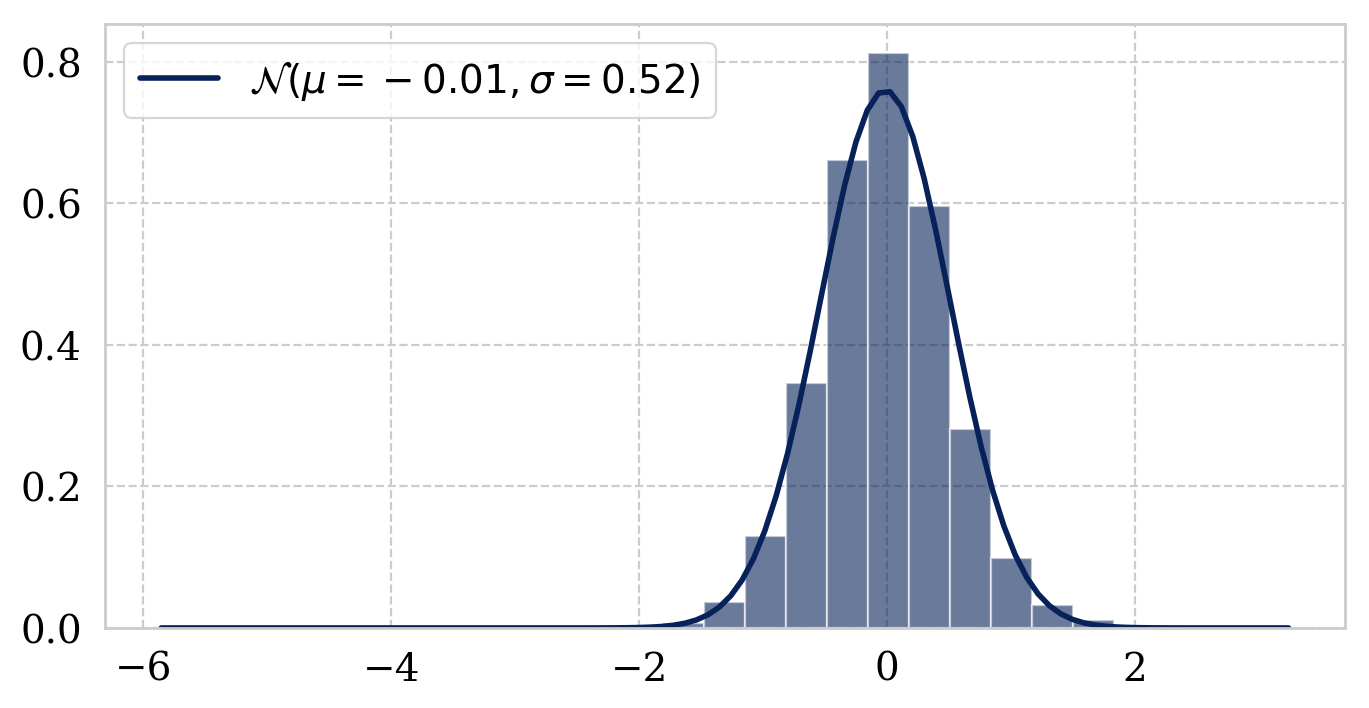

In [46]:
S = 1
MIN_NUMBER_OF_RESIDUALS = len(y_valid[:, 0])


res = [create_residual_distribution(signal = i, plot = True) for i in range(3)]

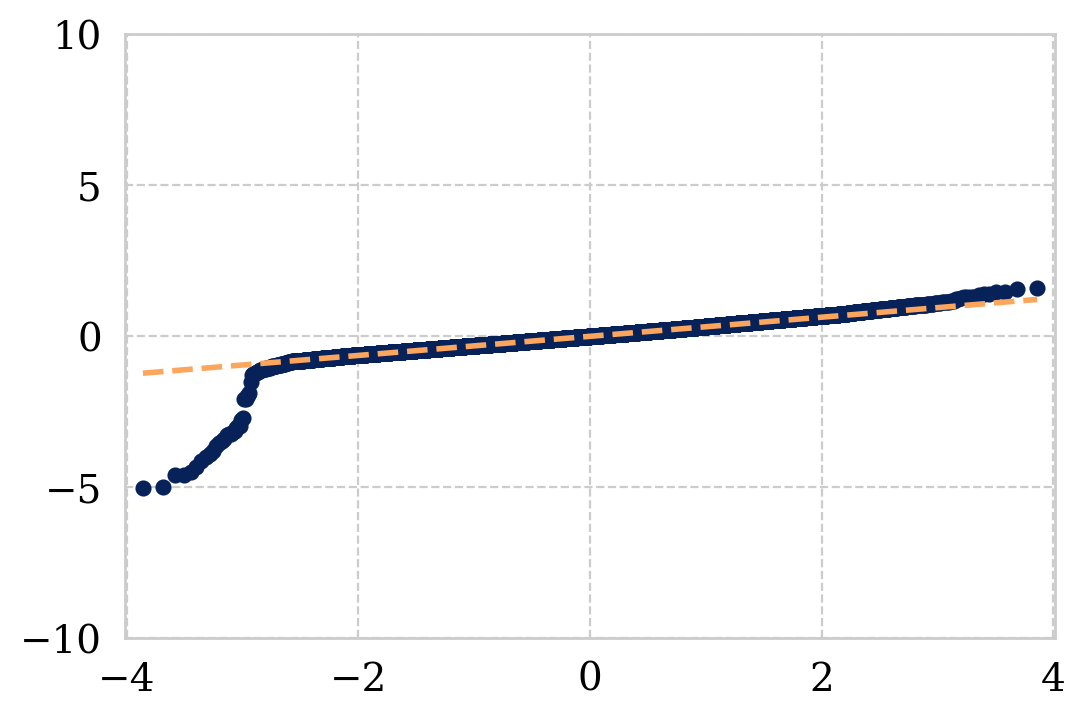

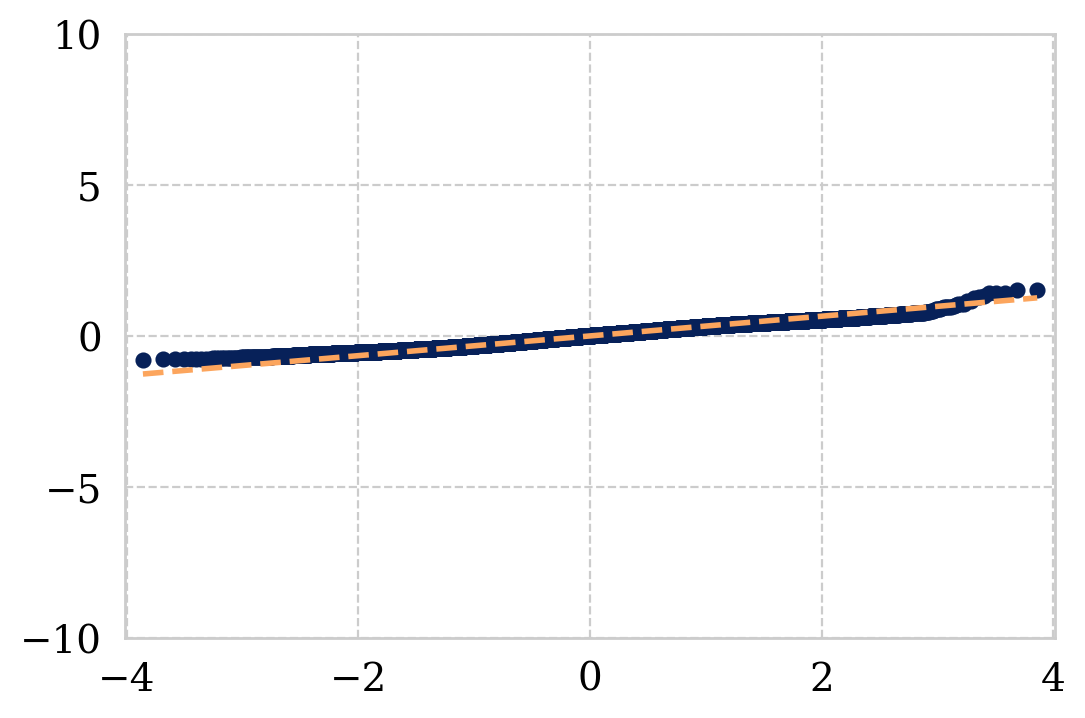

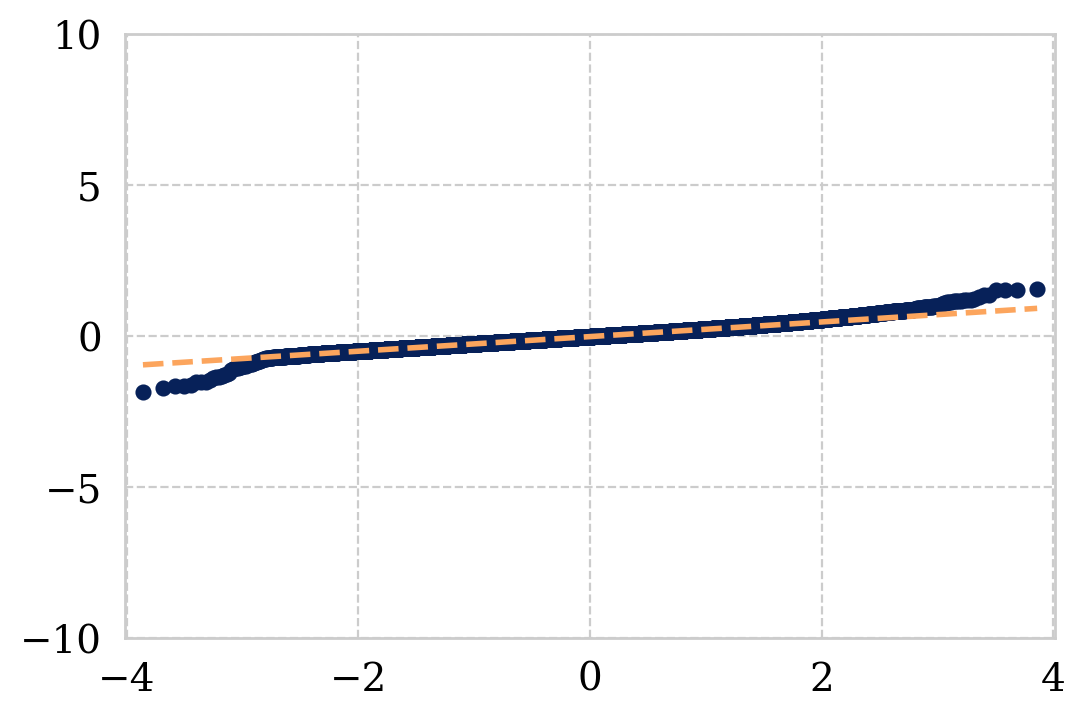

In [47]:
for i in range(len(res)):
    dist = res[i]
    
    fig, ax = plt.subplots(1,1,figsize=(6,4), dpi=200)
    ax.set_ylim(-10,10)
    p = qqplot(dist, line='q', ax=ax, c=c["blue_dark"])
    dots = fig.findobj(lambda x: hasattr(x, 'get_color') and x.get_color() == 'r')
    [d.set_linestyle('--') for d in dots]
    [d.set_color(c["orange_light"]) for d in dots]
    [d.set_linewidth(2) for d in dots]
    
    ax.set_ylabel("")
    ax.set_xlabel("")
    fig.show()

## Define anomalies

In [48]:
def get_ranges(x):
    ranges = list()
    if len(x > 0):
        index = x[0] 
    else:
        return ranges
    
    for i, value in enumerate(x):
        if (i == len(x) - 1):
            break
        if (value != (x[i + 1] - 1)):
            if (abs(index - x[i])) < 1:
                index = x[i+1]
            else:
                ranges.append((index, x[i]))
                index = x[i+1]
    return ranges

In [49]:
def define_anomalies(x,y,tau,start,end):
    
    a_rs = [get_ranges(np.where(abs(y[:, signal][start:end]) > tau)[0]) for signal in range(0,3)]
    a_rs = list(itertools.chain(*a_rs))
    a_rs = sorted(a_rs)

    a_rs_d = [(x[a_r[0]], x[a_r[1]]) for a_r in a_rs]


    positions = [111]
    fig = plt.figure(figsize=(12, 6))

    ax = fig.add_subplot(1,1,1)
    ax.plot(x[::DELTA], y[:,0][start:end][::DELTA], label="FT", c = "darkblue")
    ax.plot(x[::DELTA], y[:,1][start:end][::DELTA], label="TT", c = "darkred")
    ax.plot(x[::DELTA], y[:,2][start:end][::DELTA], label="PT", c = "darkgreen")
    [ax.axvspan(a[0], a[1], alpha=0.3, color='grey', lw = 4) for a in a_rs_d]
    ax.axhline(y=tau,lw=1, linestyle='--')
    ax.axhline(y=-tau,lw=1, linestyle='--')
    ax.set_ylim(-10, 10)
    ax.legend()
    
    return a_rs_d

## Probabilistic anomaly detection

In [50]:
# Plot results
def get_number_of_days_with_anomaly(al, threshold, x = t_12):
    predicted_anomalies = x[np.where((al > threshold) == True)[0]]
    
    num_days_with_anomalies = (len({(i.day,i.month,i.year) for i in [pd.to_datetime(date) for date in predicted_anomalies]}))
    total_num_days = (len({(i.day,i.month,i.year) for i in [pd.to_datetime(date) for date in x]}))
    
    return num_days_with_anomalies, total_num_days
    

def plot_probabilistic_anomalies(anomaly_likelihoods, 
                                 y_pred, 
                                 y_hat,
                                 dt,
                                 a_rs_d,
                                 start, 
                                 end,
                                 signal = 0, 
                                 threshold = 0.6, 
                                 verbose = True, 
                                 unit = ""):
    
    x = dt[start:end]
    plt.figure(figsize=(12, 4), dpi=200) #create one of the figures that must appear with the chart

    gs = gridspec.GridSpec(3,1)

    ax = plt.subplot(gs[2, :])
    
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))
    
    ax.plot(
        x[::2], 
        anomaly_likelihoods[start:end][::2],
        c=c["blue_dark"], 
        lw=0,
        marker='o',
        ms=1,
        label = "Log Anomaly Likelihood"
    )
    
    ax.axhline(
        y=threshold, 
        c=c["gray"], 
        linestyle='--'
    )
    
    ax.set_ylim(0, 1.05)
    
    if len(ax.get_xticklabels())>8: 
        for label in ax.get_xticklabels()[1::2]:
            label.set_visible(False)
    
    ax = plt.subplot(gs[:2, :]) #create the second subplot, that MIGHT be there
    
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%h %H:%M'))
    
    
    
    ax.set_xticklabels([])
    
    ax.plot(
        x[::DELTA], 
        y_hat[:, signal][start:end][::DELTA], 
        c=c["red"], 
        label = "Predicted",
        lw=1.5
    )
    
    ax.plot(
        x[::DELTA],
        y_pred[:,signal][start:end][::DELTA], 
        c=c["blue_med"], 
        label = "Actual",
        lw=1.5
    )
    
    if len(ax.get_xticklabels())>8: 
        for label in ax.get_xticklabels()[1::2]:
            label.set_visible(False)

    red_marks = x[np.where((anomaly_likelihoods[start:end] > threshold) == True)[0]]
    [ax.axvspan(red_marks[i], red_marks[i], alpha=0.4, color='pink', lw=13) for i in range(0, len(red_marks) - 1)]
    
    if signal==0: 
        ylabels = [str(int(i//1000)) + "k" for i in ax.get_yticks()]
        ax.set_yticklabels(ylabels)
    
    ax.legend(frameon=True)
    plt.show()


In [51]:
def tailProbability(x, mu, sigma):
    z = (x - mu) / sigma
    return 1.0 - 0.5 * math.erfc(z / np.sqrt(2))

def calculate_anomaly_score(residuals):
     return np.mean(residuals[-NUM_AVERAGED_ANOMALY_SCORES:])

def calculate_anomaly_likelihood(
    residuals,
    y, 
    y_hat, 
    mu,
    sigma,
):
    anomaly_score = calculate_anomaly_score(residuals = residuals)
    anomaly_likelihood = tailProbability(anomaly_score, mu, sigma)
    
    if log_likelihood:
        return np.log(1.0000000001 - 2 * abs(0.5 - anomaly_likelihood)) / np.log(1.0 - 0.9999999999)
    else:
        return abs(0.5 - anomaly_likelihood)

In [52]:
log_likelihood = True
NUM_AVERAGED_ANOMALY_SCORES = 15

def run(y_hat, start, end, a_rs_d = [], plot = True, y_pred = y_12, dt = t_12, threshold = 0.6):
    residuals = np.zeros(len(y_pred))
    anomaly_likelihoods = [np.zeros(len(y_pred)) for i in range (0, 3)]
    
    for signal in range(0, 3):
        res_dist = create_residual_distribution(signal = signal, plot = False)
        (mu, sigma) = getattr(scstats, 'norm').fit(res_dist)
        
        for index in range(start, end):    
            residual = y_hat[:,signal][index] - y_pred[:,signal][index]
            residuals[index] = residual
            
            anomaly_likelihoods[signal][index] = calculate_anomaly_likelihood(
                residuals = residuals[(index - NUM_AVERAGED_ANOMALY_SCORES): (index + 1)],
                y = y_pred,
                y_hat = y_hat,
                mu = mu,
                sigma = sigma
            )
        
        if plot:
            plot_probabilistic_anomalies(
                signal = signal, 
                anomaly_likelihoods = anomaly_likelihoods[signal],
                y_pred = y_pred,
                y_hat = y_hat,
                dt = dt,
                threshold = threshold,
                a_rs_d = a_rs_d
            )
        
    return anomaly_likelihoods

In [53]:
anomaly_likelihoods_12 = run(
    start = start_dec,
    end = end_dec,
    plot = False, 
    y_pred = y_12, 
    y_hat = y_hat_12, 
    dt = t_12, 
    threshold = 0.8,
)

In [54]:
anomaly_likelihoods_04 = run(
    start = start_april, 
    end = end_april,
    plot = False, 
    y_pred = y_04, 
    y_hat = y_hat_04, 
    dt = t_04, 
    threshold = 0.8,
    a_rs_d = [],
)

In [55]:
anomaly_likelihoods_07 = run(
    start = start_july, 
    end = end_july,
    plot = False, 
    y_pred = y_07, 
    y_hat = y_hat_07, 
    dt = t_07, 
    threshold = 0.8,
    a_rs_d = [],
)

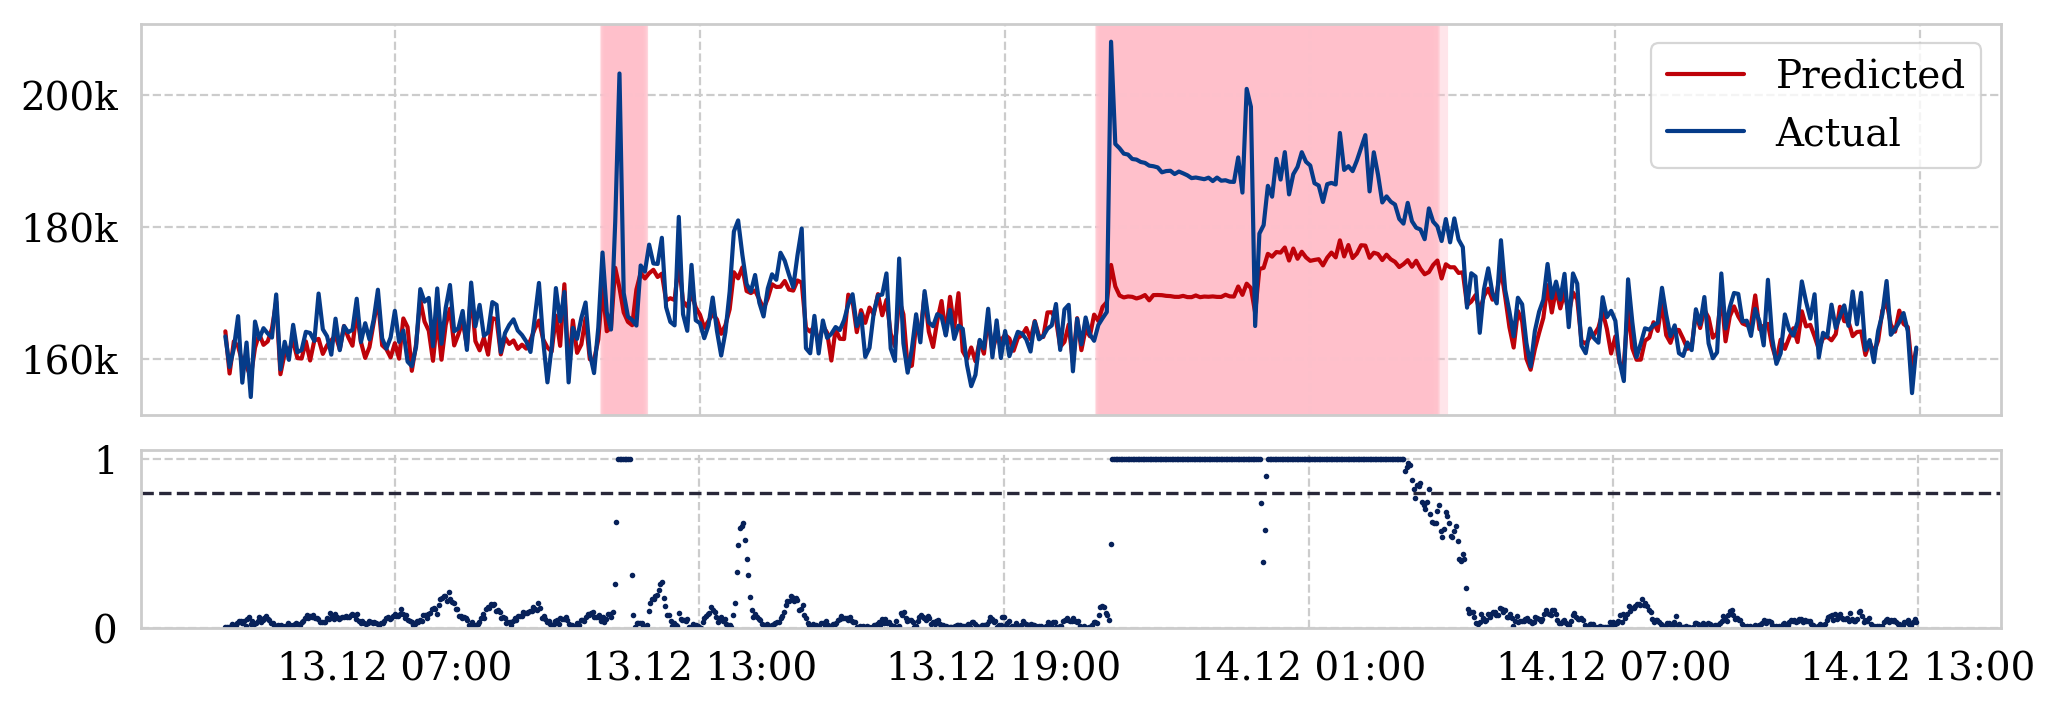

In [56]:
signal = 0
DELTA=5
mean = stats.iloc[signal, :]["Mean"]
std = stats.iloc[signal, :]["Std"]

plot_probabilistic_anomalies(
    start = start_dec,
    end = end_dec,
    y_hat = (y_hat_12 * std) + mean,
    y_pred = (y_12 * std) + mean,
    dt = t_12,
    a_rs_d = [],
    anomaly_likelihoods = anomaly_likelihoods_12[signal], 
    signal = signal,
    threshold = 0.8,
    unit = "kg/h"
)

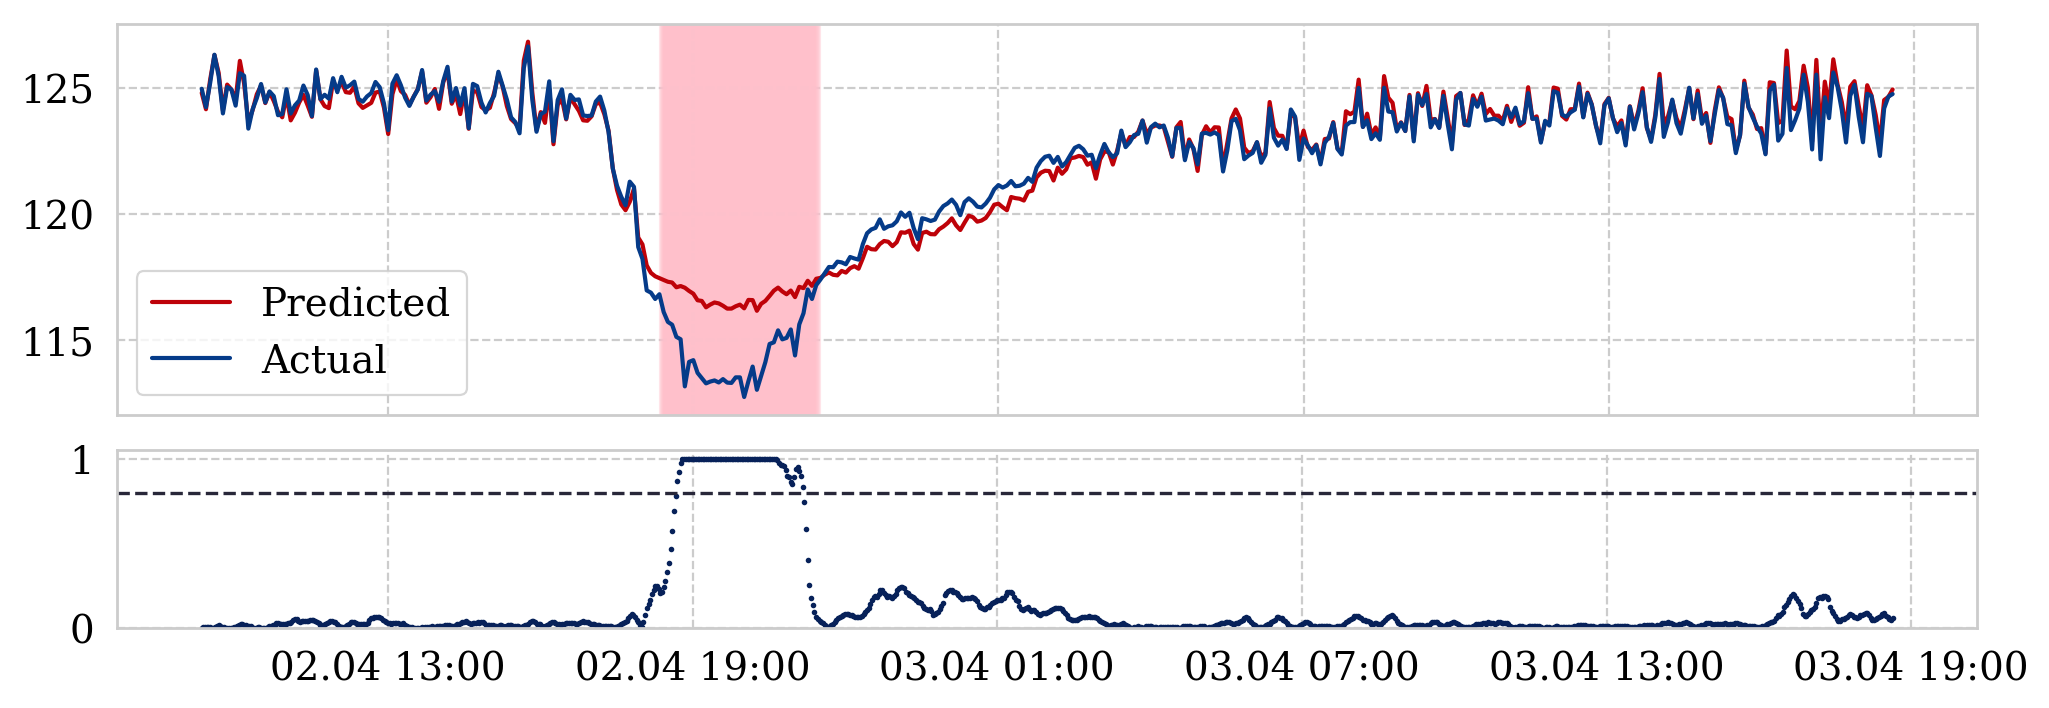

In [57]:
# April
signal = 1
mean = stats.iloc[signal, :]["Mean"]
std = stats.iloc[signal, :]["Std"]

plot_probabilistic_anomalies(
    start = start_april,
    end = end_april, 
    y_hat = (y_hat_04 * std) + mean,
    y_pred = (y_04 * std) + mean,
    dt = t_04,
    a_rs_d = [],
    anomaly_likelihoods = anomaly_likelihoods_04[signal], 
    signal = signal,
    threshold = 0.8,
    unit = "$^\circ$C"
)

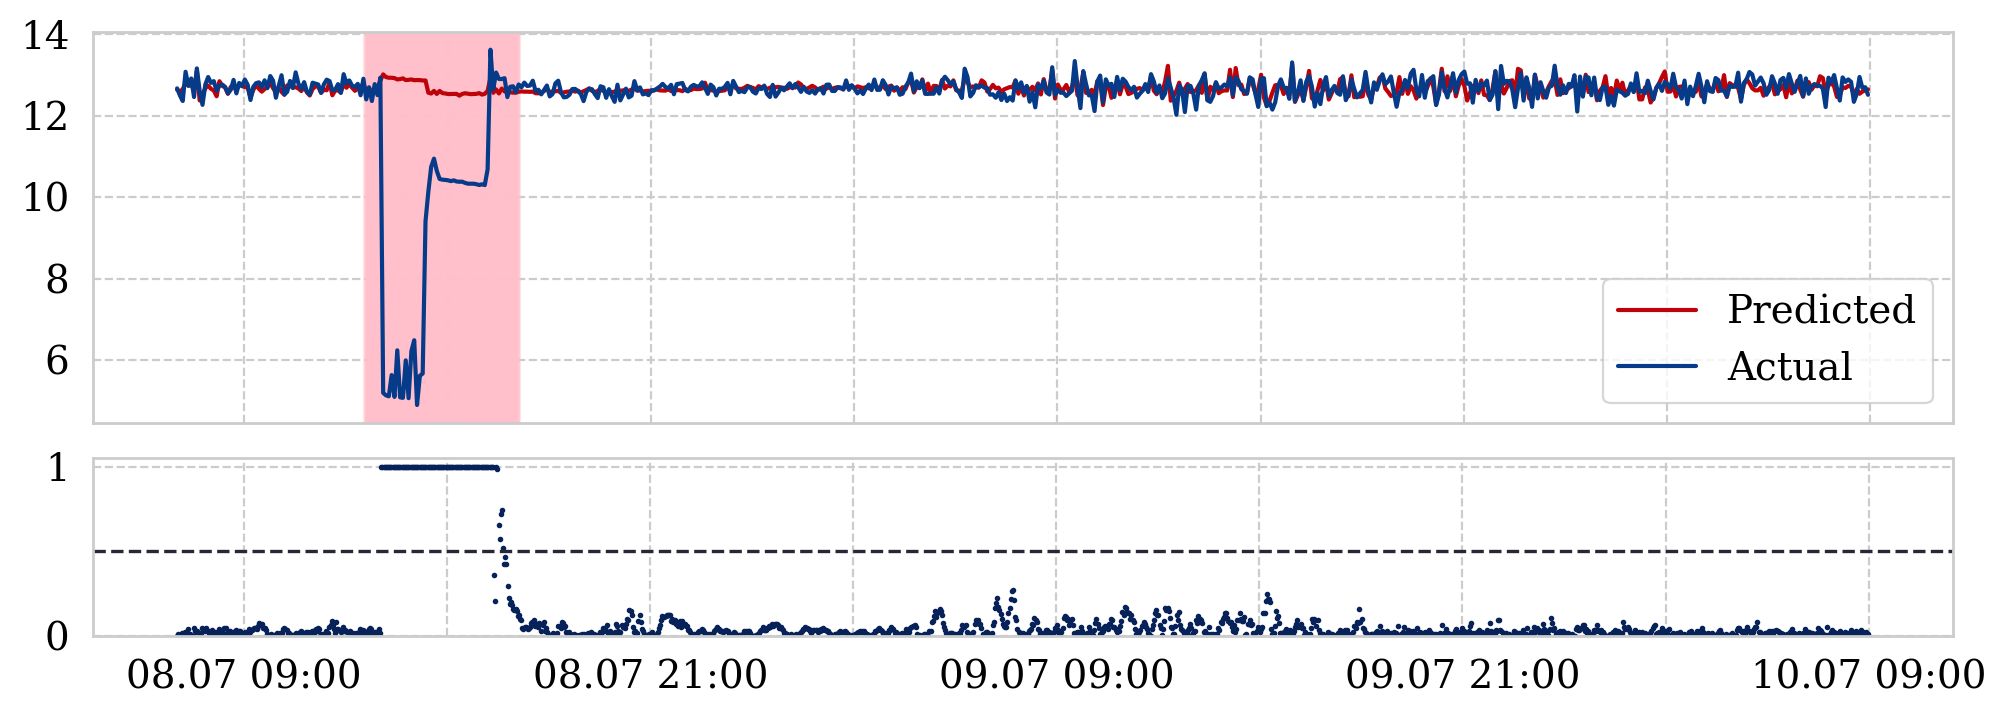

In [58]:
# JULY
signal = 2
mean = stats.iloc[signal, :]["Mean"]
std = stats.iloc[signal, :]["Std"]

plot_probabilistic_anomalies(
    start = start_july,
    end = end_july,
    y_hat = (y_hat_07 * std) + mean,
    y_pred = (y_07 * std) + mean,
    dt = t_07,
    a_rs_d = [],
    anomaly_likelihoods = anomaly_likelihoods_07[signal], 
    signal = signal,
    threshold = 0.5,
    unit = "barg"
)

## Threshold analysis

In [ ]:
signal = 1
num_days_with_anomaly, total_num_days = get_number_of_days_with_anomaly(
    anomaly_likelihoods_04[signal], 
    x = t_04,
    threshold = 0.95
)

print('===== NUMBER OF DAYS WITH ANOMALIES: {anomalies} out of {total} days for signal {signal} ====='.format(
    anomalies = num_days_with_anomaly,
    total = total_num_days,
    signal = signal,
))

In [ ]:
num_anomalies = np.zeros((9, 11))

In [ ]:
verbose = False
step_size = 100.0
num_anomalies = np.zeros((9, int(step_size + 1)))

for signal in range(0, 9):
    if signal < 3:
        anomaly_likelihoods = anomaly_likelihoods_12
        x = t_12
    elif signal < 6:
        anomaly_likelihoods = anomaly_likelihoods_04
        x = t_04
    else:
        anomaly_likelihoods = anomaly_likelihoods_07
        x = t_07
        
    for threshold in range(10, int(step_size + 1)):
        num_days_with_anomaly, total_num_days = get_number_of_days_with_anomaly(
            anomaly_likelihoods[signal % 3], 
            x = x,
            threshold = (threshold / step_size)
        )
        num_anomalies[signal, threshold] = num_days_with_anomaly
        
        if verbose:
            print('===== \
                  NUMBER OF DAYS WITH ANOMALIES: {anomalies} out of {total} days \
                  for signal {signal} with threshold {threshold} \
                  in period {period} \
                  ====='.format(
                anomalies = num_days_with_anomaly,
                total = total_num_days,
                signal = signal % 3,
                threshold = threshold / step_size,
                period = signal % 3,
            ))

In [465]:
sns.set_palette(sns.color_palette("bright", 9))
# current_palette = sns.color_palette("colorblind", 9)
# sns.palplot(current_palette)


fig, ax = plt.subplots(1,1, figsize(6,6), dpi=200)
x = np.linspace(0, 1, step_size + 1)
ax = fig.add_subplot(111)

ax.plot(x, num_anomalies[0, :], label = "FT December", linestyle = '--', lw = 1)
ax.plot(x, num_anomalies[1, :], label = "TT December", linestyle = '--', lw = 1)
ax.plot(x, num_anomalies[2, :], label = "PT December", linestyle = '--', lw = 1)

ax.plot(x, num_anomalies[3, :], label = "FT April", linestyle = '-.', lw = 1)
ax.plot(x, num_anomalies[4, :], label = "TT April", linestyle = '-.', lw = 1)
ax.plot(x, num_anomalies[5, :], label = "PT April", linestyle = '-.', lw = 1)

ax.plot(x, num_anomalies[6, :], label = "FT July", lw = 1)
ax.plot(x, num_anomalies[7, :], label = "TT July", lw = 1)
ax.plot(x, num_anomalies[8, :], label = "PT July", lw = 1)

ax.set_ylim(0, 30)
ax.set_xlim(0.1, 1)



ax.set_ylabel('Number of Days')
ax.set_xlabel(r'$\tau$')
ax.legend()

NameError: name 'figsize' is not defined

## PI Anomaly Detection

In [64]:
def get_ranges_pi(x):
    ranges = list()
    
    for i, value in enumerate(x):
        if (i == len(x) - 1):
            break
        if ((value and x[i - 1] and x[i - 2] and x[i - 3] and x[i - 5])):
            ranges.append(i)
    return ranges

In [65]:
def pi_anomaly_detection(y_hat, y_actual, t, std_preds, start, end, signal, alpha = 2.33, unstandardized = True, plot = True):
    x = t[start:end]
    std = stats.loc[:,"Std"][signal]
    mean = stats.loc[:,"Mean"][signal]
    
    if (unstandardized):        
        lower_pi = (y_hat[:, signal] - alpha * std_preds[:, signal]) * std + mean
        upper_pi = (y_hat[:, signal] + alpha * std_preds[:, signal]) * std + mean
        
        y_hat = (y_hat * std) + mean
        y_actual = (y_actual * std) + mean
    else:
        lower_pi = y_hat[:, signal] - alpha * std_preds[:, signal]
        upper_pi = y_hat[:, signal] + alpha * std_preds[:, signal]
        
        y_hat = y_hat
        y_actual = y_actual
        

    predicted_anomalies = [
        y_actual[:, signal][start:end][i] > upper_pi[start:end][i] or 
        y_actual[:, signal][start:end][i] < lower_pi[start:end][i] for i in range(0, end - start)
    ]
    
    #print("{}% of the observations are outside the prediction interval".format(round(float(sum(predicted_anomalies) / len(predicted_anomalies) * 100), 1)))

    if plot:
        fig, ax = plt.subplots(1,1,figsize=(12,4), dpi=200)
        
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))

        ax.plot(x[::DELTA], lower_pi[start:end][::DELTA], color = "darkgray")
        ax.plot(x[::DELTA], upper_pi[start:end][::DELTA], color = "darkgray")

        ax.fill_between(x[::DELTA], lower_pi[start:end][::DELTA], upper_pi[start:end][::DELTA], color='grey', alpha='0.3')
        ax.plot(x[::DELTA], y_hat[:, signal][start:end][::DELTA], label = "Predicted", color=c["red"], lw=1.5)
        ax.plot(x[::DELTA], y_actual[:, signal][start:end][::DELTA], label = "Actual", color=c["blue_med"], lw=1.5)

        red_marks = x[get_ranges_pi(predicted_anomalies)]    
        [ax.axvspan(red_marks[i], red_marks[i], alpha=0.4, lw=13, color="pink") for i in range(0, len(red_marks) - 1)]
        
        if len(ax.get_xticklabels())>8: 
            for label in ax.get_xticklabels()[1::2]:
                label.set_visible(False)
                
        if signal==0: 
            ylabels = [str(int(i//1000)) + "k" for i in ax.get_yticks()]
            ax.set_yticklabels(ylabels)
            
        if signal!=2: 
            for label in ax.get_yticklabels()[1::2]:
                label.set_visible(False)
            

        leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                  ncol=2, fancybox=True, shadow=False, frameon=False)
        for legobj in leg.legendHandles:
            legobj.set_linewidth(3.0)

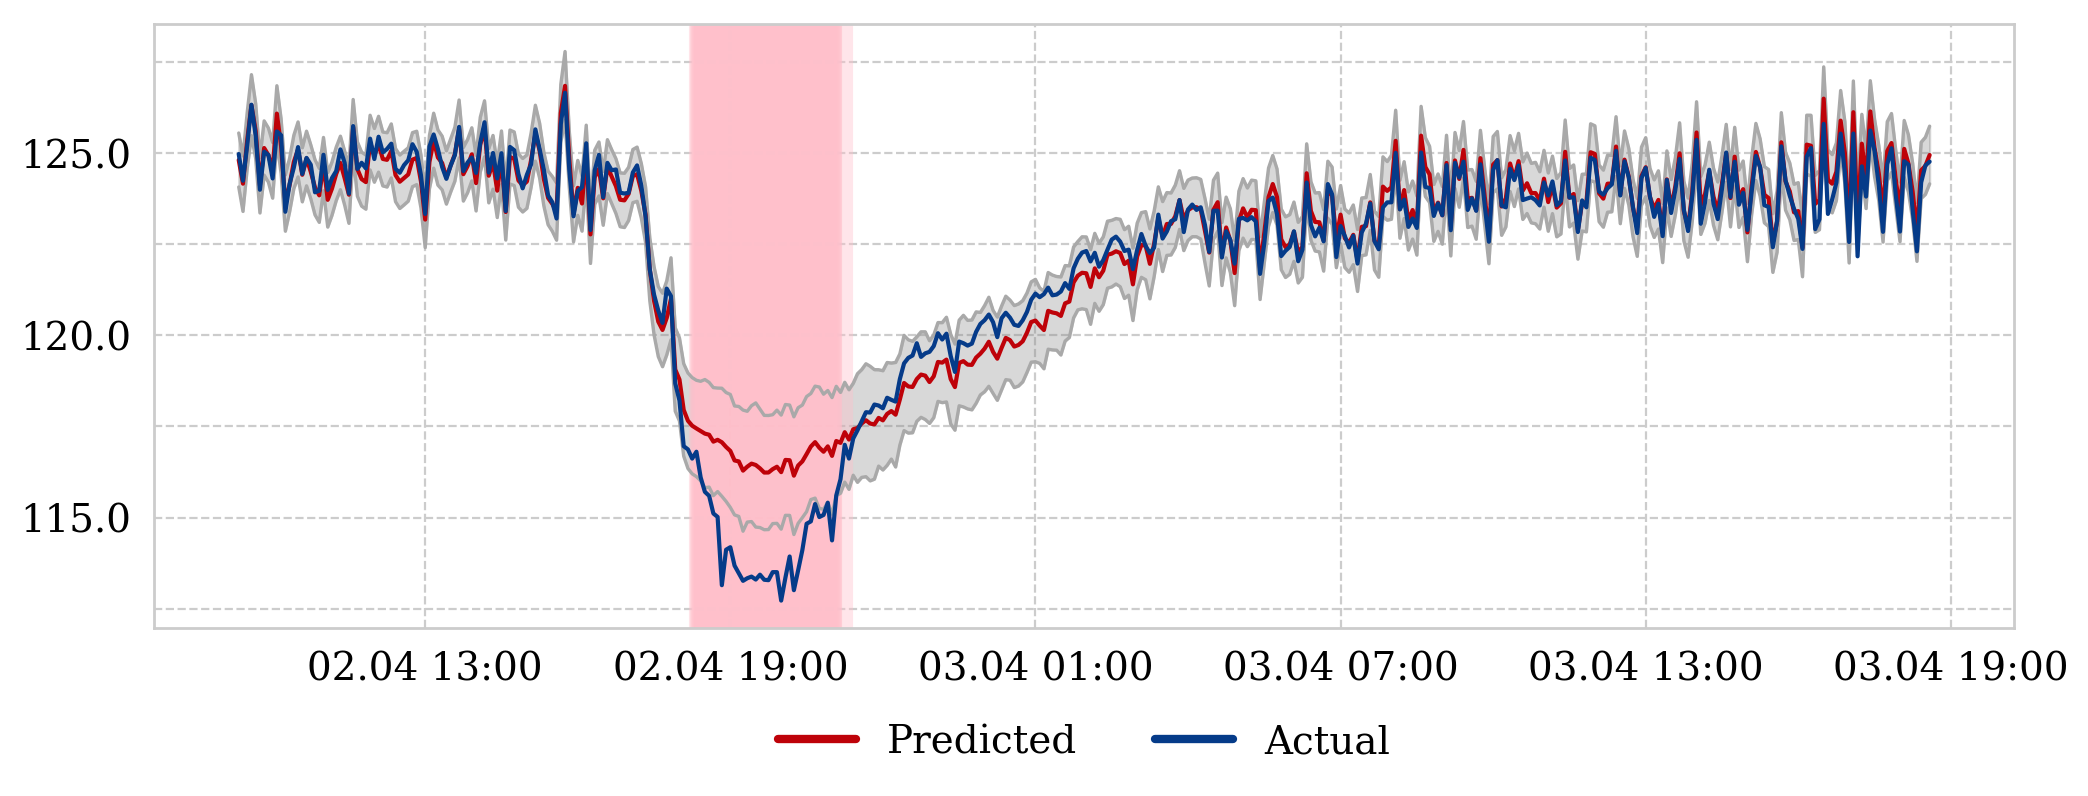

In [66]:
pi_anomaly_detection(
    start = start_april,
    end = end_april,
    y_hat = y_hat_04, 
    y_actual = y_04, 
    t = t_04, 
    std_preds = std_preds_04,
    signal=1,
    unstandardized = True,
    plot = True
)

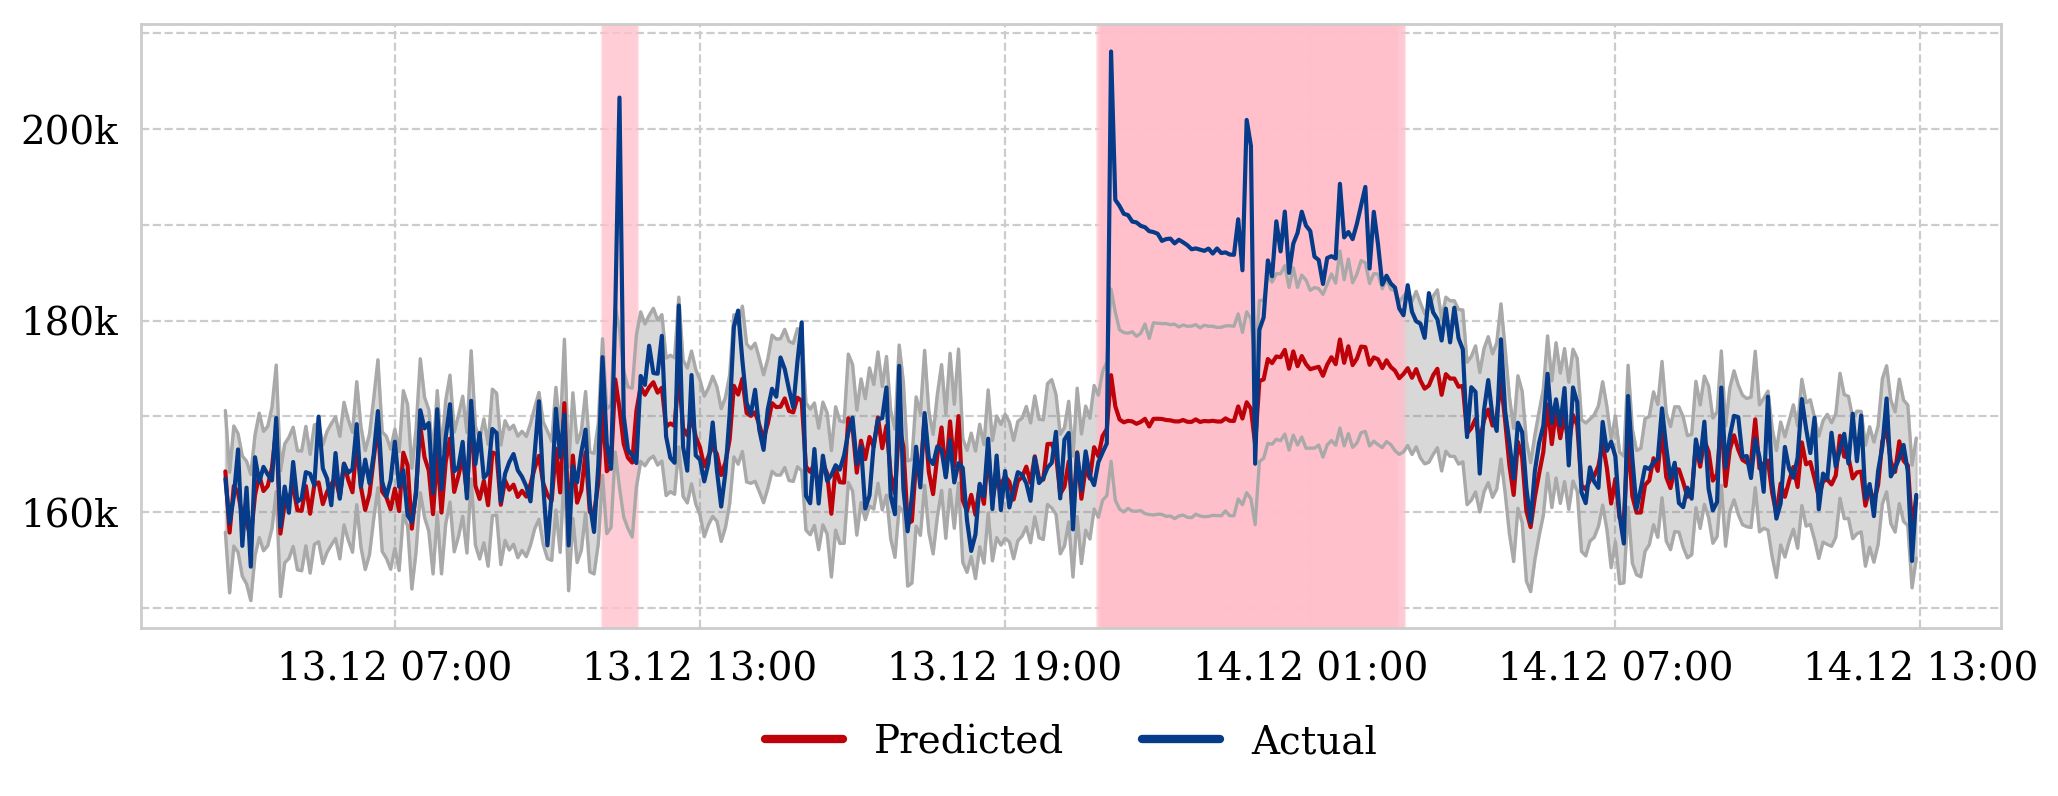

In [67]:
pi_anomaly_detection(
    start = start_dec,
    end = end_dec,
    y_hat = y_hat_12, 
    y_actual = y_12, 
    t = t_12, 
    signal=0,
    std_preds = std_preds_12,
    unstandardized = True,
    plot = True
)

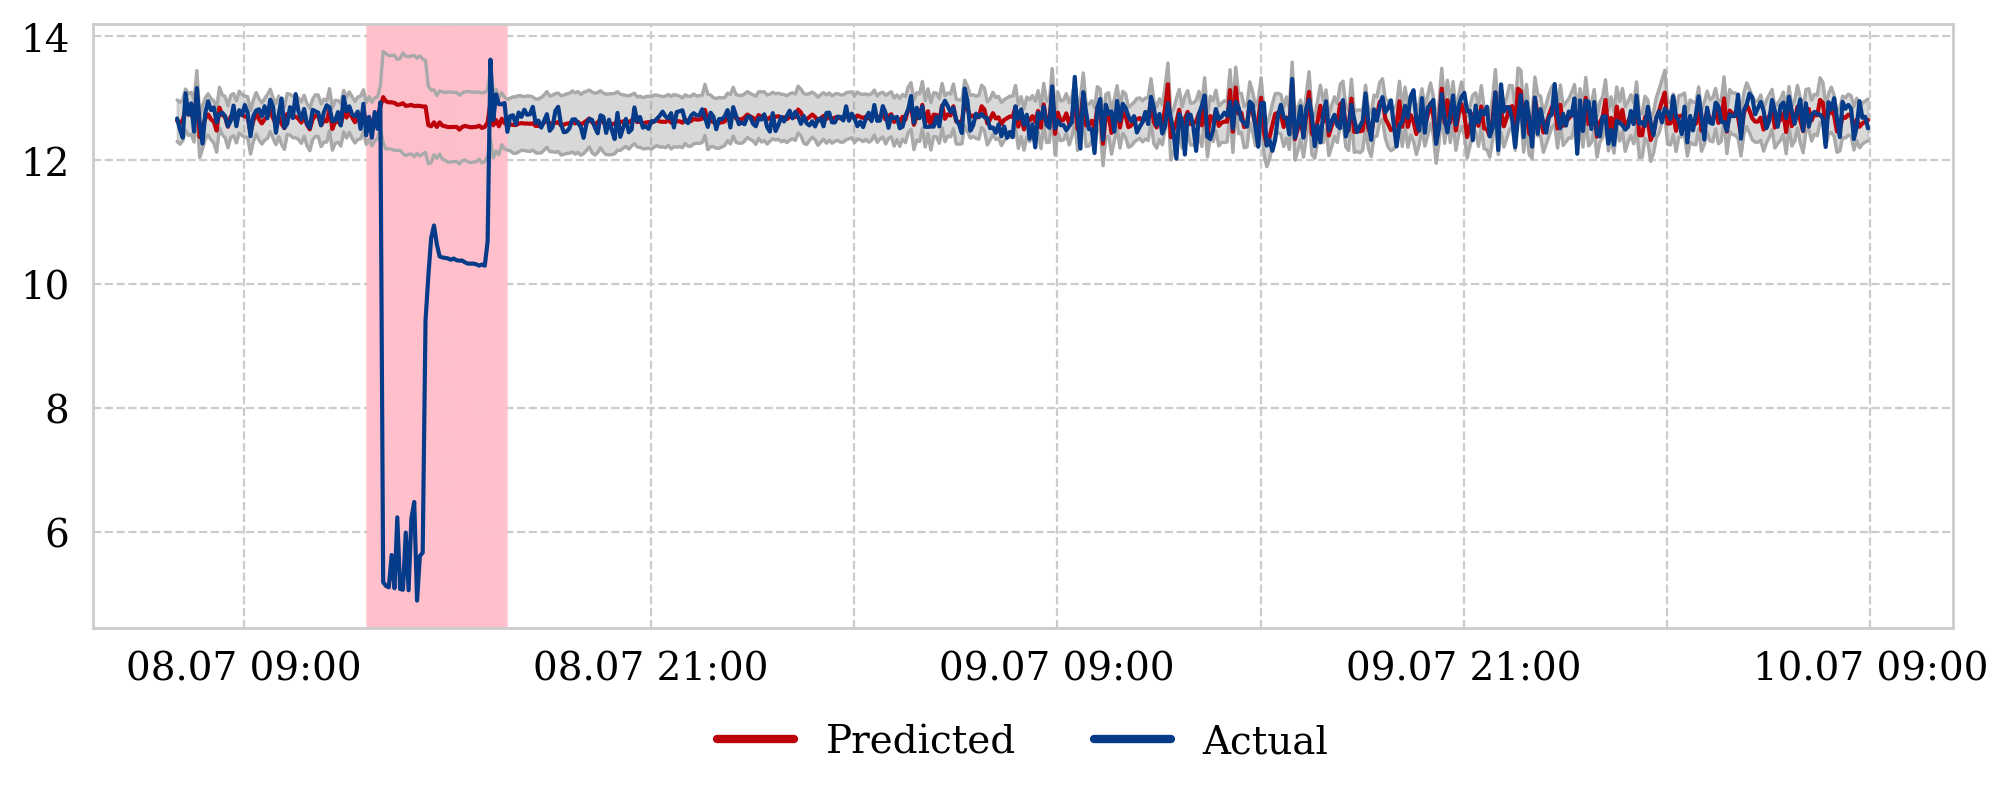

In [68]:
pi_anomaly_detection(
    start = start_july,
    end = end_july,
    y_hat = y_hat_07, 
    y_actual = y_07, 
    t = t_07, 
    signal=2,
    std_preds = std_preds_07,
    unstandardized = True,
    plot = True
)